# RARL for Fire Search and Rescue
# INITIAL DQN

# Imports

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install mdptoolbox.example

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,047 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,681 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRe

In [ ]:
# If this errors the first time run it again
from IPython.utils.sysinfo import encoding
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import tensorflow as tf
import numpy as np
import copy

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tensorflow.python.ops.linalg_ops import batch_matrix_solve_eager_fallback

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import gym
import numpy as np
import time, pickle, os
import random
import matplotlib.pyplot as plt

tf.compat.v1.enable_v2_behavior()

In [ ]:
# Install openmesh
# !pip install openmesh

# Visualization libraries
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import torch

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple, Any, Iterable

# We'll use a namedtuple to store scene information in an accessible way
from collections import namedtuple

In [ ]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from scipy.signal import convolve2d

def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

Mounted at /content/drive


# CHANGE THESE FOR YOUR LOCAL PATHS

In [ ]:
from google.colab import drive

# CHANGE THESE PATH VARIABLES
drive.mount('/content/drive')
map='/content/drive/MyDrive/forest_env.png'
color_reduced_map='/content/drive/MyDrive/color_reduced_image.PNG'
#map='/content/cognitive_robotics_img.PNG'
#color_reduced_map='/content/cognitive_robotics_img.PNG'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Environment Building

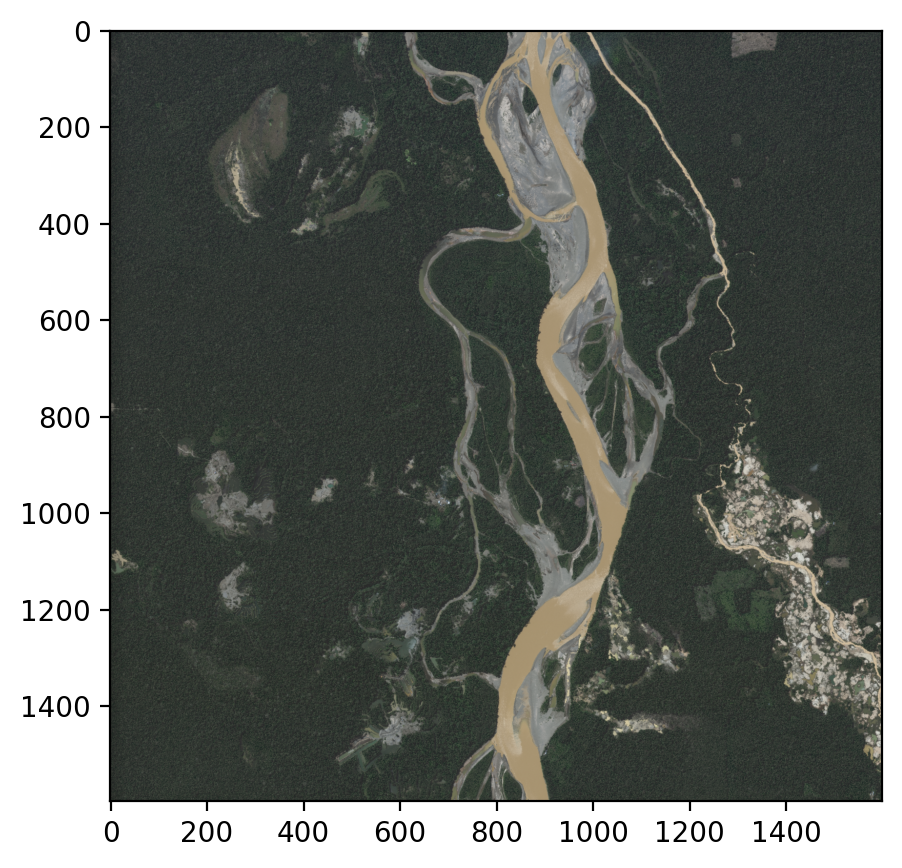

In [ ]:
def img2arr(img):
  arr = cv2.imread(img)
  return arr

def arr2img(arr, figuresize):
  # Smaller (downsampled) image
  plt.figure(figsize=figuresize) # for downsampling
  plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))
  plt.show()

#map='/content/cognitive_robotics_img.PNG'
img_arr = img2arr(map)
h,w,_ = img_arr.shape
#resized = cv2.resize(img_arr, (75, 75), interpolation = cv2.INTER_AREA)
resized = img_arr
arr2img(resized, (5,5))


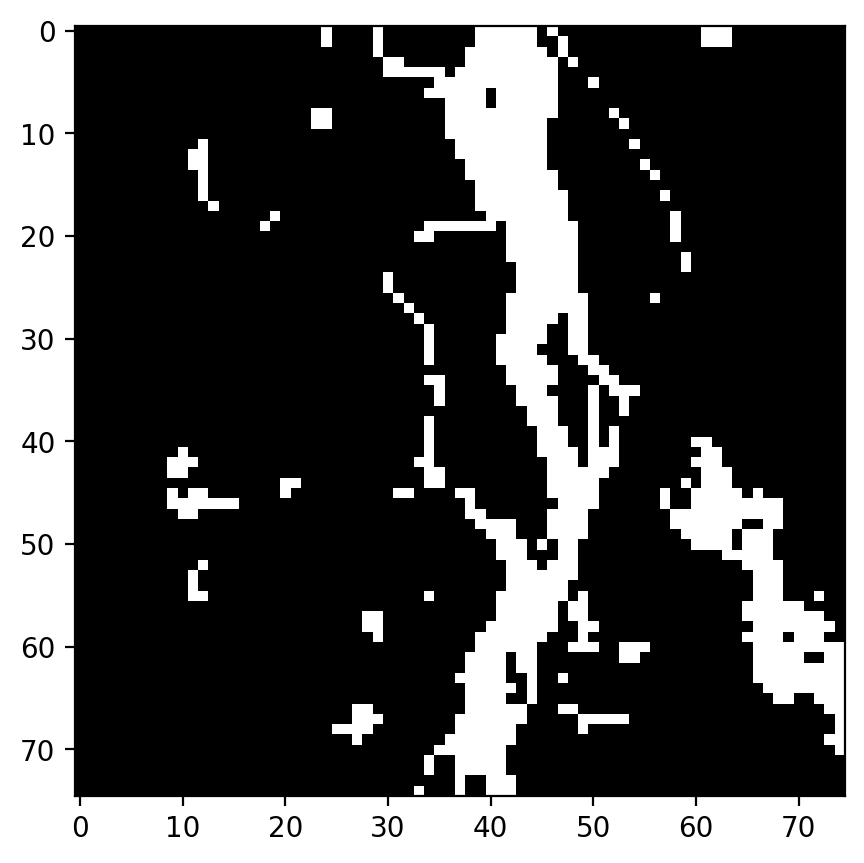

In [ ]:
# https://onlinejpgtools.com/reduce-jpg-colors
# color reducer
#color_reduced_map='/content/cognitive_robotics_img.PNG'
color_reduced_arr = img2arr(color_reduced_map)
h,w,_ = color_reduced_arr.shape
resized = cv2.resize(color_reduced_arr, (75, 75), interpolation = cv2.INTER_AREA)
thresh = np.where(resized > (np.max(resized)+np.min(resized))/2, 255, 0)
img_float32 = np.float32(thresh)
arr2img(img_float32, (5,5))


In [ ]:
def redo_board(observation):
  # 0 = black (0,0,0)
  # 1 = white (255,255,255)
  # 3 = fire = red (255,0,0)
  # drone = blue (0,0,255)
  # person = green (0,255,0)
  colors = {0:np.array([0,0,0]), 1:np.array([225,225,225]), 3:np.array([255,0,0])}
  board_size = len(observation)-2
  image = np.zeros((board_size, 3))
  for i in range(board_size):
    image[i,:] = colors[observation[i]]
  image[observation[-2],:] = np.array([0,0,255])
  image[observation[-1],:] = np.array([0,225,0])

  image = image.reshape(int(board_size**0.5), int(board_size**0.5), 3)
  return image
  #ax.imshow(image)
  axis_image = ax.imshow(image)
  return axis_image

In [ ]:
def show_board(observation, ax=plt, frames_changed=True):
  # 0 = black (0,0,0)
  # 1 = white (255,255,255)
  # 3 = fire = red (255,0,0)
  # drone = blue (0,0,255)
  # person = green (0,255,0)
  image = observation
  if frames_changed == False:
    image = redo_board(observation)
  axis_image = ax.imshow(image)
  return axis_image

In [ ]:
# Animation wrapper to make it easy to display a series of frames in colab
class AnimationWrapper():
    def __init__(self, rows, cols, frames, figsize=(8, 6)):
        self.rows, self.cols = rows, cols
        self.frames = frames
        for i in range(len(frames)):
          self.frames[i][0] = redo_board(frames[i][0])
          
        
        self.fig = plt.figure(figsize=figsize)
        self.axes = []
        self.axis_images = []
        self.data = []
        self.pbar = None
        for r in range(rows):
            for c in range(cols):
                ax = plt.subplot(rows, cols, r * cols + c + 1)
                img = show_board(frames[0][r * cols + c], ax=ax)
                
                self.axes.append(ax)
                self.axis_images.append(img)
                self.data.append([])
        plt.close()
        
        # Set maximal limit to 100 MB, default is 20 MB
        matplotlib.rcParams['animation.embed_limit'] = 100
    
    def get_axes(self):
        return self.axes
    
    def animate(self, i):
        self.pbar.update(1)
            
        for ax_id in range(len(self.axis_images)):
            frame = self.frames[i][ax_id]
            if len(frame.shape) == 3:
                self.axis_images[ax_id].set_data(frame[:,:,:])
            else:
                depth = frame.copy()
                depth[np.isnan(depth)] = depth[~np.isnan(depth)].min()
                self.axis_images[ax_id].set_data(depth)
                self.axis_images[ax_id].set_clim(depth.min(), depth.max())
        return tuple(self.axis_images)
    
    def generate(self):
        self.pbar = tqdm.tqdm(total = len(self.frames), position=0, leave=True, desc="Building animation... ")
        self.anim = animation.FuncAnimation(self.fig, self.animate, frames=len(self.frames), interval=100, blit=True)
        
        # Note: below is the part which makes it work on Colab
        rc('animation', html='jshtml')

# DQN

Based on:  
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial  
https://github.com/tensorflow/agents/issues/339  
https://www.mikulskibartosz.name/how-to-train-a-reinforcement-learning-agent-using-tensorflow-agents/



In [ ]:
import numpy as np
import tensorflow as tf
from tf_agents.environments import utils
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.trajectories import time_step as ts
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.specs import tensor_spec

In [ ]:
# DQN parameters
# https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
num_iterations = 15000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

In [ ]:
class ForestFireEnvironment(py_environment.PyEnvironment):
  def __init__(self, board_configuration=None, fire_seed=None, drone_location=None, person_location=None):
    self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
    self.moves = {0:(0,-1), 1:(0,1), 2:(-1,0), 3:(1,0)}
    self._discount = 0.99
    self.height = board_configuration.shape[0]
    self.width = board_configuration.shape[1]
    self.board = np.array(copy.deepcopy(board_configuration)).flatten() # STAYS THE SAME
    self.init_board = np.array(copy.deepcopy(board_configuration)).flatten()
    self._init_drone = self.__coord2idx(drone_location)
    self._init_person = self.__coord2idx(person_location) # STAYS THE SAME
    self._init_fire = self.__coord2idx(fire_seed)
    self.board[self._init_fire] = 3
    self.init_board[self._init_fire] = 3
    self._state = np.concatenate((self.board, np.array([self._init_drone]), np.array([self._init_person])))
    self._init_state = np.concatenate((self.init_board, np.array([self._init_drone]), np.array([self._init_person])))
    self._episode_ended = False
    self.count = 0
    self._observation_spec = array_spec.BoundedArraySpec(
        shape = (self._state.shape), dtype=np.int32, minimum=0, maximum=self.width*self.height-1, name="observation"
    )

  def __idx2coord(self, idx):
    return (idx%self.width, idx//self.width)

  def __coord2idx(self, coords):
    return coords[0] + coords[1]*self.width

  def _reset(self):
    if self._board_configuration is None:
        self.board = self.__create_board(self._board_size)
    else:
        self.board = np.copy(self._board_configuration)

    self.episode_ended = False
    self.steps = 0
    self.drone_location = self._init_drone
    self.person_location = self._init_person
    self.board[self.drone_location] = 1
    self.board[self.person_location] = 2

    observation = self.__idx2coord(self.drone_location) + self.__idx2coord(self.person_location)
    return ts.restart(np.array(observation, dtype=np.int32))

  def __spread_fire(self, fire_locations):
    thresh = 0.9
    directions = [(0,1),(0,-1),(1,0),(-1,0)]
    new_fire_locations = fire_locations.copy()
    neighbors = set()
    for loc in fire_locations:
      for dir in directions:
        new_loc = (loc[0]+dir[0],loc[1]+dir[1])
        if self.__in_bounds(new_loc) and new_loc not in fire_locations and new_loc not in neighbors:
          neighbors.add(new_loc)
    for neighbor in neighbors:
      val = random.random()
      if val > thresh:
        new_fire_locations.add(neighbor)
    return new_fire_locations

  def __in_bounds(self, coord):
    if coord[0] >= 0 and coord[1] >= 0 and coord[1] < self.height and coord[0] < self.width:
      return True
    return False

  def __can_move(self, drone, action, fire):
    new_loc = (drone[0]+action[0], drone[1]+action[1])
    if self.__in_bounds(new_loc) and new_loc not in fire:
      return True
    return False

  def __compress_board(self, fire, drone):
    new_board = np.copy(self.init_board)
    for pos in fire:
      posidx = self.__coord2idx(pos)
      new_board[posidx] = 3
    droneidx = self.__coord2idx(drone)
    new_board = np.concatenate((new_board, np.array([droneidx]), np.array([self._init_person])))
    return new_board

  def __extract_board(self):
    fire_locations = set()
    for i, pos in enumerate(self._state):
      if pos == 3 and i < self.width * self.height: # fire
        fire_locations.add(i)
    drone_location = self._state[-2] 
    return fire_locations, drone_location
  
  def _reset(self):
      self.count = 0
      self._state = np.copy(self._init_state)
      self._episode_ended = False
      return ts.restart(np.array(self._state, dtype=np.int32))

  def __is_near_fire(self, drone, fire):
    directions = [(0,1),(0,-1),(1,0),(-1,0)]
    for dir in directions:
      new_loc = (drone[0]+dir[0], drone[1]+dir[1])
      if new_loc in fire:
        return True
    return False

  def _step(self, action):
      action = self.moves[int(action)]
      fire, drone = self.__extract_board()
      fire = {self.__idx2coord(idx) for idx in fire}
      drone = self.__idx2coord(drone)
      self.count += 1
      
      if self._episode_ended: 
          return self.reset()
      
      if self.count >= 10000:
          self._episode_ended = True
          return ts.termination(np.array(self._state, dtype=np.int32), reward= 0 )
      elif self.__can_move(drone, action, fire): 
          new_loc = (drone[0] + action[0], drone[1] + action[1])
          if new_loc == self._init_person: 
              self._episode_ended = True
              return ts.termination(np.array(self._state, dtype=np.int32), reward= 100)
          else: 
              drone = new_loc
              fire = self.__spread_fire(fire)
              self._state = self.__compress_board(fire, drone)
              reward = -1
              if self.__is_near_fire(drone, fire):
                  reward -= 10  
              return ts.transition(np.array(self._state, dtype=np.int32), reward=reward)
      else:
          self._episode_ended = True
          return ts.termination(np.array(self._state, dtype=np.int32), reward=-100)

  def _current_time_step(self):
    return self.current_time_step()

  def getBoard(self):
    return self.board

  def action_spec(self):
    return self._action_spec # 0,1,2,3 correspond to directions in moves

  def observation_spec(self):
    return self._observation_spec

In [ ]:
from tf_agents.trajectories import time_step as ts

In [ ]:
map = (img_float32[:,:,0] > 5).astype(int)
test_map = map[:15,:15]
fire_seed = (1,1)
drone_location = (5,5)
person_location = (13,13)
environment = ForestFireEnvironment(board_configuration=test_map, fire_seed=fire_seed, drone_location=drone_location, person_location=person_location)
train_py_env = tf_py_environment.TFPyEnvironment(environment)
eval_py_env = tf_py_environment.TFPyEnvironment(environment)


In [ ]:
fc_layer_params = (100,)
q_net = q_network.QNetwork(train_py_env.observation_spec(), train_py_env.action_spec(), fc_layer_params=fc_layer_params)


In [ ]:
# DQN Agent
# https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)


# https://github.com/tensorflow/agents/issues/339
# generally 100:1 ration of initial_learning_rate:end_learning_rate
epsilon = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=num_iterations // 2,
    end_learning_rate=0.01)

# create DQN agent
agent = dqn_agent.DqnAgent(
    train_py_env.time_step_spec(),
    train_py_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy=lambda: epsilon(train_step_counter),
)

agent.initialize()


In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_py_env.batch_size,
    max_length=replay_buffer_max_length)


In [ ]:
dynamic_step_driver.DynamicStepDriver(
    train_py_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps).run()
    

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 227), dtype=int32, numpy=
 array([[  3,   3,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   3,   3,   3,   3,   3,   3,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   3,   3,   3,   3,   3,   3,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   3,   3,   3,   3,   3,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   3,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   3,   3,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
           3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]
    

In [ ]:
for _ in range(num_iterations):
    # replaces time_step, _ = collect_driver.run(time_step)
    # https://www.mikulskibartosz.name/how-to-train-a-reinforcement-learning-agent-using-tensorflow-agents/
    # for _ in range(collect_steps_per_iteration):
    dynamic_step_driver.DynamicStepDriver(
        train_py_env,
        agent.collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=collect_steps_per_iteration).run()

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_py_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 26.237560272216797
step = 400: loss = 16.714176177978516
step = 600: loss = 12.07214641571045
step = 800: loss = 3.7123239040374756
step = 1000: loss = 42.24889373779297
step = 1000: Average Return = -105.0
step = 1200: loss = 4.31886100769043
step = 1400: loss = 22.97569465637207
step = 1600: loss = 186549.125
step = 1800: loss = 1268778.0
step = 2000: loss = 6088821.0
step = 2000: Average Return = -109.0
step = 2200: loss = 21883984.0
step = 2400: loss = 4155831.5
step = 2600: loss = 6385200.0
step = 2800: loss = 3149246.5
step = 3000: loss = 3434843.75
step = 3000: Average Return = -111.0
step = 3200: loss = 5906146.5
step = 3400: loss = 335233.1875
step = 3600: loss = 4140352.5
step = 3800: loss = 384309.0625
step = 4000: loss = 2842860.0
step = 4000: Average Return = -126.4000015258789
step = 4200: loss = 1298526.375
step = 4400: loss = 3539172.0
step = 4600: loss = 909612.3125
step = 4800: loss = 178206.03125
step = 5000: loss = 138009.25
step = 5000: Average R

In [ ]:
def find_path(environment, policy):
    path = []
    time_step = environment.reset()
    while not time_step.is_last():
        action_step = policy.action(time_step._replace(observation=np.array([time_step.observation])))
        action = action_step.action
        time_step = environment.step(action)
        path.append(action.numpy()[0])
    return path

In [ ]:
path = find_path(environment, agent.policy)
print("Path:", path)

Path: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
observes = []
for i in path:
  # curr_dir = random.randint(0,3)
  curr = environment._step(i)
  curr_observe = curr.observation
  observes.append([curr_observe])
path_animation = AnimationWrapper(rows=1, cols=1, frames=observes)
path_animation.generate()
path_animation.anim

Building animation... :  90%|█████████ | 9/10 [00:00<00:00,  9.09it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Building animation... : 11it [00:01,  8.18it/s]                       WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Building animation... : 12it [00:01,  8.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Building animation... : 13it [00:01,  7.84it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
# FOR CLASS DEMO
path = [1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3, 3, 3, 3, 3, 3]
observes = []
for i in path:
  curr = env._step(i)
  curr_observe = curr.observation
  observes.append([curr_observe])
path_animation = AnimationWrapper(rows=1, cols=1, frames=observes)
path_animation.generate()
path_animation.anim

Building animation... : 100%|██████████| 45/45 [00:04<00:00,  9.16it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Building animation... : 46it [00:04,  8.56it/s]                        WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Building animation... : 47it [00:04,  8.69it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Building animation... : 48it [00:04,  8.98it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
# Output path
drone_loc = (5, 5)
target_loc = (13, 13)

action_dict = {0:(0,-1), 1:(0,1), 2:(-1,0), 3:(1,0)}
path_tuple = [(5, 5)]

for action in path:
  action_tuple = action_dict[action]
  drone_loc = tuple(i + j for i, j in zip(drone_loc, action_tuple))
  path_tuple.append(drone_loc)

print(path_tuple)

[(5, 5), (5, 6), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9), (9, 10), (9, 9), (9, 10), (9, 11), (9, 10), (9, 11), (9, 10), (9, 9), (9, 10), (9, 9), (9, 10), (9, 9), (9, 8), (9, 9), (9, 8), (9, 9), (9, 8), (9, 9), (9, 8), (9, 7), (9, 8), (9, 7), (9, 6), (9, 7), (9, 6), (9, 7), (9, 6), (9, 7), (9, 8), (9, 7), (9, 6), (10, 6), (11, 6), (12, 6), (13, 6), (14, 6), (15, 6)]
